# Compression and serialization of seismic wavefields 

This brief notebook is aimed at learning by manipulation the essentials of compression and serialization for a realistic finite difference modeled wavefield.

## Types of compression in this micro-benchmark
| type  | notes          | website(s) |
|:------|:---------------|:-----------|
| raw   | no compression |            |
| gzip  | lossless       | in python  | 
| lzma  | lossless       | in python  | 
| bz2   | lossless       | in python  | 
| blosc | lossy          | https://blosc.org, https://github.com/Blosc/python-blosc | 
| zfp   | lossy          | https://computing.llnl.gov/projects/floating-point-compression, https://pypi.org/project/pyzfp | 

## Outline
1. setup a small 2D seismic modeling example 
1. generate wavefields to compress
1. exercise compression algorithms and benchmark
  * compression ratio
  * execution time

## Use of Memoryview
Add comments about use of memoryview to provide a copy free conversion from Devito wavefield arrays to raw bytes.


## Use of blosc compression

This micro-benchmark includes the blosc copmpressor (https://blosc.org) via ```python-blosc``` (https://github.com/Blosc/python-blosc). The python wrapper is installed via pip into this jupyter kernel in the next cell.

In [25]:
# NBVAL_IGNORE_OUTPUT

# Install the blosc package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install blosc

## Use of zfp compression

This micro-benchmark includes the zfp copmpressor (https://computing.llnl.gov/projects/floating-point-compression) via ```pyzfp``` (https://pypi.org/project/pyzfp). The python wrapper is installed via pip into this jupyter kernel in the next cell.

### zfp parameterization

We hardwire the parameters ```tolerance``` and ```parallel``` here for use with ```zfp``` below.

In [26]:
# # NBVAL_IGNORE_OUTPUT

# # Install the pyzfp package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install pyzfp

# tolerance = 1.e-7
# parallel = True

# from pyzfp import compress as pyzfp_compress
# from pyzfp import decompress as pyzfp_decompress

## Devito related imports grouped here

In [27]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm)
from examples.seismic.self_adjoint import (acoustic_sa_setup, setup_w_over_q,
                                           SaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Setup the model and acoustic wave solver

We will use the self-adjoint system from examples/seismic/self-adjoint.

In [28]:
# NBVAL_IGNORE_OUTPUT

# Setup time / frequency
nt = 451
dt = 1.5
tmin = 0.0
tmax = dt * (nt - 1)
fpeak = 0.010
omega = 2.0 * np.pi * fpeak
time_axis = TimeAxis(start=tmin, stop=tmax, step=dt)
time = np.linspace(tmin, tmax, nt)

# Model
space_order = 8
npad = 10
dx, dz = 10, 10
nx, nz = 251, 251
shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

dtype = np.float64
qmin = 0.1
qmax = 100000
v0 = np.ones(shape) # velocity
b0 = np.ones(shape) # buoyancy

# make a wacky discontinuous model to generate reflections
v0[:,0*nz//4:2*nz//4] = 1.5
v0[:,2*nz//4:4*nz//4] = 2.0

b0[1*nx//4,:] = 0.25
b0[2*nx//4,:] = 0.25
b0[3*nx//4,:] = 0.25

b0[:,1*nz//4] = 0.25
b0[:,2*nz//4] = 0.25
b0[:,3*nz//4] = 0.25

# Model
init_damp = lambda func, nbl: setup_w_over_q(func, omega, qmin, qmax, npad, sigma=0)
model = Model(origin=origin, shape=shape, vp=v0, b=b0, spacing=spacing, nbl=npad,
              space_order=space_order, bcs=init_damp, dtype=dtype, dt=dt)
print(model.critical_dt)

# Source and reciver coordinates 
src_coords = np.empty((1, 2), dtype=dtype)
src_coords[:,0] = dx * (nx-1) / 2
src_coords[:,1] = dz * (nz-1) / 2

rec_coords = np.empty((nz, 2), dtype=dtype)
rec_coords[:,0] = dx * (nx-1) / 2
rec_coords[:,1] = np.linspace(0.0, dz*(nz-1), nz)

geometry = AcquisitionGeometry(model, rec_coords, src_coords,
                               t0=0.0, tn=tmax, src_type='Ricker', f0=fpeak)

# Solver setup 
solver = SaIsoAcousticWaveSolver(model, geometry, space_order=space_order)

# Solution -- note we save all time steps for use in the compression tests
d, u, _ = solver.forward(dt=dt, save=nt)

dmin, dmax = np.min(d.data[:]), np.max(d.data[:])
umin, umax = np.min(u.data[:]), np.max(u.data[:])

print("Receiver wavefield min/max; %+12.6e %+12.6e" % (dmin, dmax))
print("Total    wavefield min/max; %+12.6e %+12.6e" % (umin, umax))
print("d.data.shape; ", d.data.shape)
print("u.data.shape; ", u.data.shape)

Operator `WOverQ_Operator` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


1.5


Operator `IsoFwdOperator` run in 0.24 s


Receiver wavefield min/max; -5.437280e+01 +1.133822e+02
Total    wavefield min/max; -5.437280e+01 +1.133822e+02
d.data.shape;  (451, 251)
u.data.shape;  (451, 271, 271)


In [29]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(d))
print(norm(u))
# assert np.isclose(norm(d), 426.77574029849677, atol=0, rtol=1e-3)
# assert np.isclose(norm(u), 3571.1693487318025, atol=0, rtol=1e-3)

744.7923809335738
3865.56332854686


## Plot the computed wavefield 

So we can see what we will compress/serialize

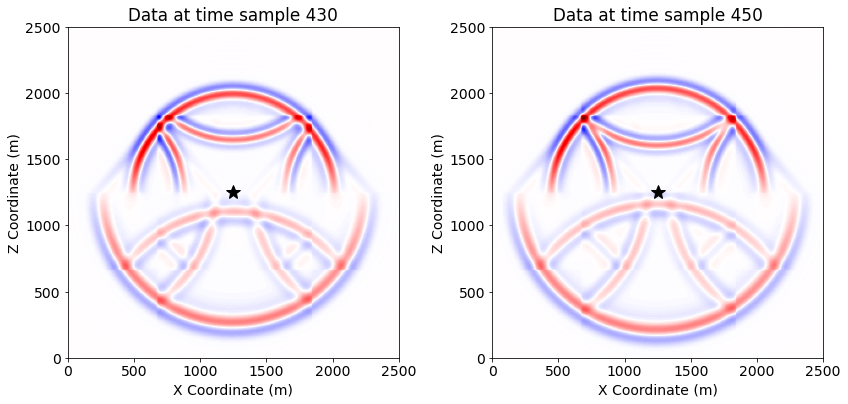

In [30]:
# NBVAL_IGNORE_OUTPUT

# The number of time steps blocked for compression/serialization
M = 20 

# Plot the two wavefields, normalized to Q=100 (the larger amplitude)
kt1 = nt - 1 - 1 * M
kt2 = nt - 1 - 0 * M 

amax = np.max(np.abs(u.data[nt-1-M:nt-1,:,:]))

plt_extent = [0, dx * (nx - 1), 0, dz * (nz - 1)]

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(u.data[kt1,:,:] / amax), cmap="seismic", 
           vmin=-1, vmax=+1, extent=plt_extent)
plt.plot(src_coords[:, 0], src_coords[:, 1], \
         'black', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Data at time sample %d" % kt1)

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(u.data[kt2,:,:] / amax), cmap="seismic",
           vmin=-1, vmax=+1, extent=plt_extent)
plt.plot(src_coords[:, 0], src_coords[:, 1], \
         'black', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Data at time sample %d" % kt2)

plt.tight_layout()
None

In [42]:
import gzip, lzma, bz2, blosc
import pprint  # for printing dictionaries below
import time    # for timing execution
from pathlib import Path # to get file size

# list of extensions
# exts = ["raw", "gzip", "lzma", "bz2", "blosc", "zfp"]
exts = ["raw", "gzip", "blosc"]

# dictionary for compression, files, sizes, and times
cmps = {
    "raw": None,
    "gzip": gzip,
    "lzma": lzma,
    "bz2": bz2,
    "blosc": None,
    "zfp": None
}

files = {}
sizes = {}
times = {}

pprint.pprint(exts)

['raw', 'gzip', 'blosc', 'zfp']


In [49]:
# use memoryview to provide a copy-free conversion to raw bytes
slice = u._data[nt-1-M:nt-1,:,:]
mv = memoryview(slice)
b = bytearray(mv)

print("u._data.shape; ", u._data.shape)
print("slice.shape;   ", slice.shape)
print("mv.shape;      ", mv.shape)

print("")
for ext in exts:
    if ext == "raw" or ext == "blosc" or ext == "zfp":
        files[ext] = open("file." + ext, "wb")
    else:
        files[ext] = cmps[ext].open("file." + ext, "wb")
        
    t1 = time.perf_counter()
    if ext == "blosc":
        print("blosc ...")
#         files[ext].write(blosc.compress(b))
#         files[ext].write(blosc.compress(b, typesize=8))
        files[ext].write(blosc.compress(b, typesize=8, cname='zlib'))
#         files[ext].write(blosc.compress(b, typesize=8, cname='blosclz'))
#         files[ext].write(blosc.compress(b, typesize=8, cname='lz4'))
    if ext == "zfp":
        files[ext].write(pyzfp_compress(slice, tolerance=tolerance, parallel=parallel))
    else:
        files[ext].write(b)
    files[ext].close()
    t2 = time.perf_counter()
    times[ext] = t2 - t1
    s = Path("file." + ext).stat().st_size / 1024**2
    sizes[ext] = s
    print("time; %8.4f sec -- size; %8.4f mb -- ratio; %8.4f %% -- type; %s" % 
          (times[ext], sizes[ext], 100 * sizes[ext] / sizes["raw"], ext))

u._data.shape;  (451, 287, 287)
slice.shape;    (20, 287, 287)
mv.shape;       (20, 287, 287)

time;   0.0135 sec -- size;  12.5685 mb -- ratio; 100.0000 % -- type; raw
time;   0.5539 sec -- size;  10.9740 mb -- ratio;  87.3131 % -- type; gzip
blosc ...
time;   0.4009 sec -- size;  22.4517 mb -- ratio; 178.6348 % -- type; blosc
time;   0.0179 sec -- size;   2.3423 mb -- ratio;  18.6365 % -- type; zfp
